# Heart Failure Prediction
## Rohan Patil

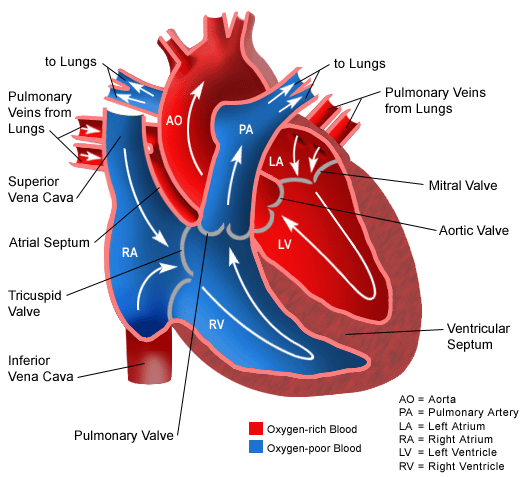

In [51]:
from IPython.display import Image
Image("heart_anatomy.jpg")

In [94]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

Data Description


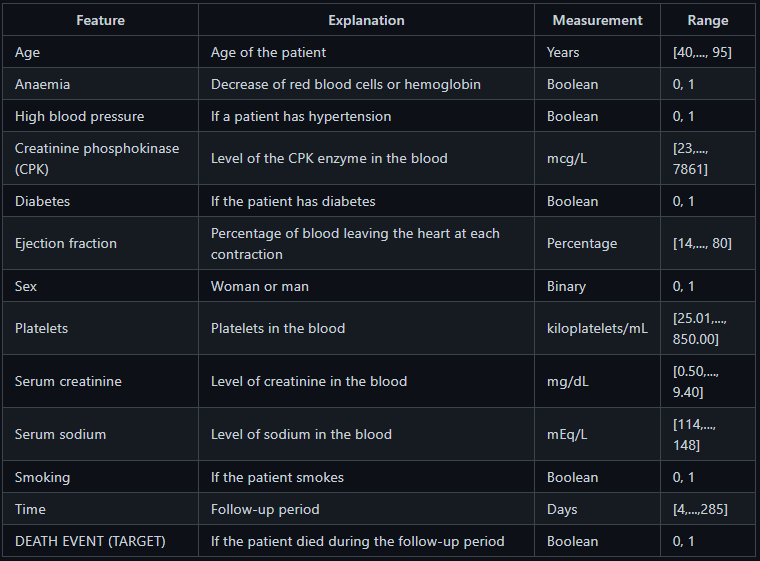

In [95]:
from IPython.display import Image
print("Data Description")
Image("data_des.png")

### Importing all necessary libraries

In [53]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder,StandardScaler
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from scipy.stats import shapiro
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,precision_score,recall_score,f1_score,roc_curve,roc_auc_score

### Importing the dataset

In [54]:
data = pd.read_csv("heart_failure_clinical_records_dataset.csv")

In [55]:
data.shape

(299, 13)

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [57]:
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


### Checking missing values

In [58]:
for i in data.columns:
    nan_counts = data[i].isna().sum()
    total = len(data[i])
    res = np.round(nan_counts/total,5)
    print('{0}% of missing value is found in {1} column'.format(res,i))

0.0% of missing value is found in age column
0.0% of missing value is found in anaemia column
0.0% of missing value is found in creatinine_phosphokinase column
0.0% of missing value is found in diabetes column
0.0% of missing value is found in ejection_fraction column
0.0% of missing value is found in high_blood_pressure column
0.0% of missing value is found in platelets column
0.0% of missing value is found in serum_creatinine column
0.0% of missing value is found in serum_sodium column
0.0% of missing value is found in sex column
0.0% of missing value is found in smoking column
0.0% of missing value is found in time column
0.0% of missing value is found in DEATH_EVENT column


##### We don't have any missing values

### Dealing with outliers in numerical fields

In [59]:
l=['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium','time']
for i in l:
    px.box(x = data[i],title=i.upper()).show()
    
    Q1 = data[i].quantile(0.25)
    Q3 = data[i].quantile(0.75)
    IQR = Q3-Q1
    upper_fence = Q3 + (1.5*IQR)
    lower_fence = Q1 - (1.5*IQR)
    
    if data[(data[i]>=upper_fence) | (data[i]<=lower_fence)].shape[0]>0:
        for k,d in data.iterrows():
            if d[i]>=upper_fence:
                data.at[k,i] = upper_fence
            if d[i]<=lower_fence:
                data.at[k,i] = lower_fence
        print("Outliers detected and removed successfully!!")
        px.box(x = data[i],title="{} without Outliers".format(i).upper()).show()
    else:
        print("No Outliers detected!!")

No Outliers detected!!


Outliers detected and removed successfully!!


Outliers detected and removed successfully!!


Outliers detected and removed successfully!!


Outliers detected and removed successfully!!


Outliers detected and removed successfully!!


No Outliers detected!!


In [60]:
data.head(5)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.90,130,1,0,4,1
1,55.0,0,1280,0,38,0,263358.03,1.10,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.30,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.90,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.15,125,0,0,8,1


### Categorical fields
##### There are 5 categorical columns. However the values are by default read as integer so we convert them into categories here.

In [61]:
categorical_col = ['anaemia','diabetes','high_blood_pressure','sex','smoking']

In [62]:
for col in categorical_col:
    data[col] = data[col].astype("category")

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   age                       299 non-null    float64 
 1   anaemia                   299 non-null    category
 2   creatinine_phosphokinase  299 non-null    int64   
 3   diabetes                  299 non-null    category
 4   ejection_fraction         299 non-null    int64   
 5   high_blood_pressure       299 non-null    category
 6   platelets                 299 non-null    float64 
 7   serum_creatinine          299 non-null    float64 
 8   serum_sodium              299 non-null    int64   
 9   sex                       299 non-null    category
 10  smoking                   299 non-null    category
 11  time                      299 non-null    int64   
 12  DEATH_EVENT               299 non-null    int64   
dtypes: category(5), float64(3), int64(5)
memory usage:

### Data Visualization

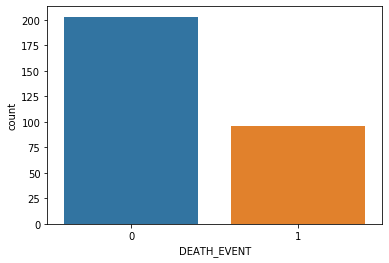

In [64]:
sns.countplot(data['DEATH_EVENT'])

##### The data is slightly imbalanced. We will have to deal with this later on during data modeling.

In [65]:
print("Select through the drop down menu to view related pie charts.")
fig = go.Figure()
col_list = ['anaemia','diabetes','high_blood_pressure','sex','smoking']
for col in col_list:
    temp = dict(data[col].value_counts())
    fig.add_trace(
      go.Pie(
          labels = list(temp.keys()),
          values =  list(temp.values())
      )
  )

fig.update_layout(
    updatemenus=[go.layout.Updatemenu(
        active=0,
        buttons=list(
            [dict(label = 'Anaemia',
                  method = 'update',
                  args = [{'visible': [True, False, False, False, False]}, 
                          {'title': 'Anaemia',
                           'showlegend':True}]),
             dict(label = 'Diabetes',
                  method = 'update',
                  args = [{'visible': [False, True, False, False, False]},
                          {'title': 'Diabetes',
                           'showlegend':True}]),
             dict(label = 'High Blood Pressure',
                  method = 'update',
                  args = [{'visible': [False,False, True, False, False]},
                          {'title': 'High Blood Pressure',
                           'showlegend':True}]),
             dict(label = 'Sex',
                  method = 'update',
                  args = [{'visible': [False, False,False,True, False]},
                          {'title': 'Sex',
                           'showlegend':True}]),
             dict(label = 'Smoking',
                  method = 'update',
                  args = [{'visible': [False,False, False, False, True]},
                          {'title': 'Smoking',
                           'showlegend':True}]),
            ])
        )
    ])

fig.show()

Select through the drop down menu to view related pie charts.


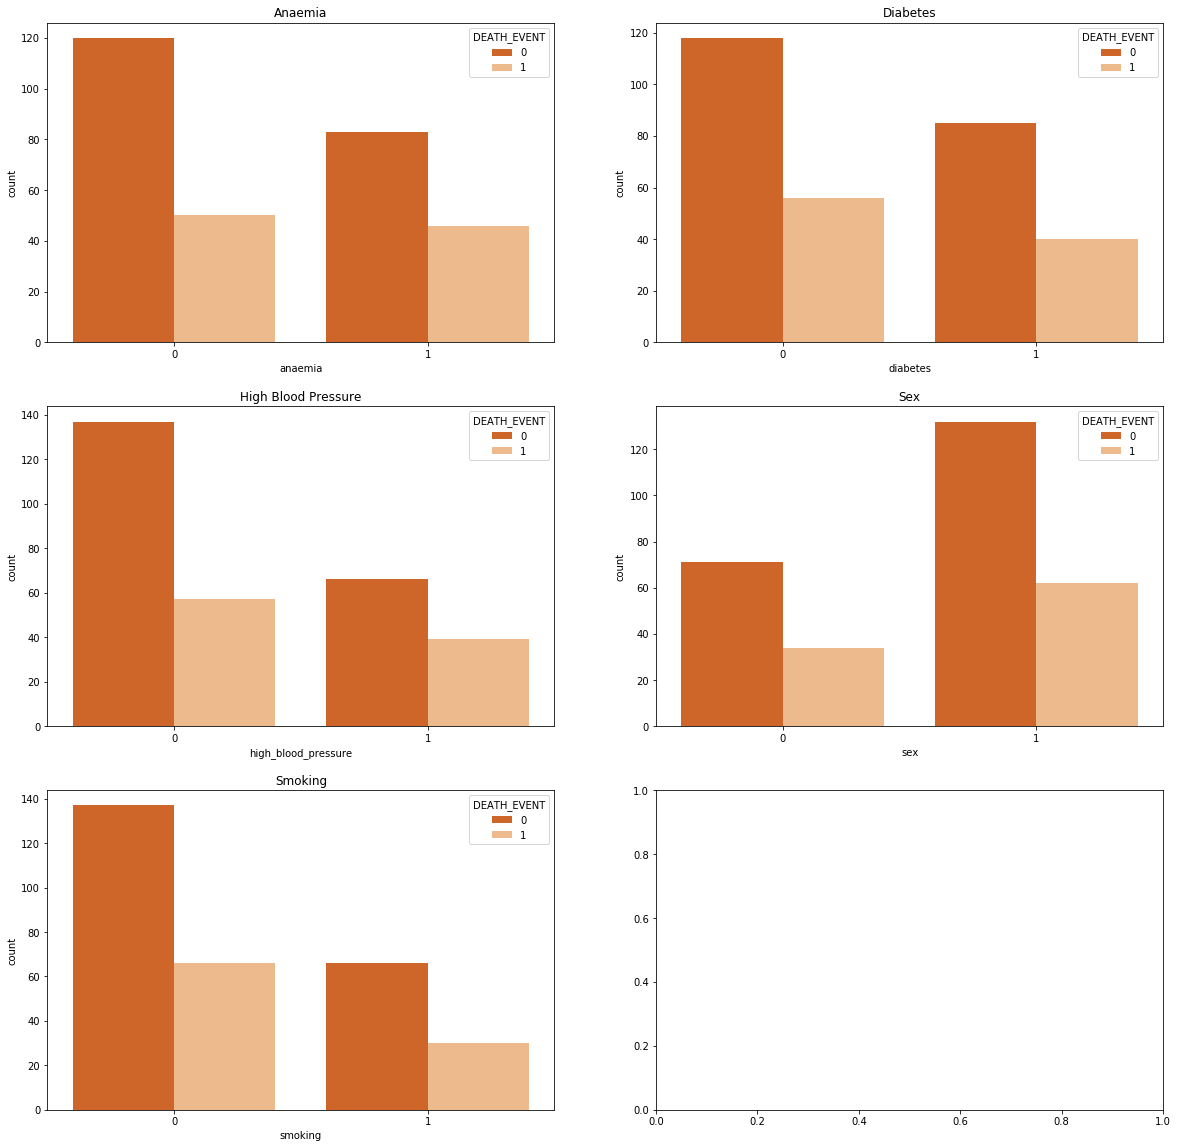

In [66]:
fig, axis = plt.subplots(3, 2, figsize=(20,20))
axis[0,0].set_title('Anaemia')
axis[0,1].set_title('Diabetes')
axis[1,0].set_title('High Blood Pressure')
axis[1,1].set_title('Sex')
axis[2,0].set_title('Smoking')

sns.countplot(x = 'anaemia', hue = 'DEATH_EVENT', data = data, palette = 'Oranges_r',ax=axis[0,0])
sns.countplot(x = 'diabetes', hue = 'DEATH_EVENT', data = data, palette = 'Oranges_r',ax=axis[0,1])
sns.countplot(x = 'high_blood_pressure', hue = 'DEATH_EVENT', data = data, palette = 'Oranges_r',ax=axis[1,0])
sns.countplot(x = 'sex', hue = 'DEATH_EVENT', data = data, palette = 'Oranges_r',ax=axis[1,1])
sns.countplot(x = 'smoking', hue = 'DEATH_EVENT', data = data, palette = 'Oranges_r',ax=axis[2,0])

plt.show()

##### These are countplots for the categorical columns in our dataset. We can observe the following

#### We next create a derived column call 'Age categories' from original column 'Age' where the age values are segregated into 5 categories.

Text(0, 0.5, 'Percentage of death')


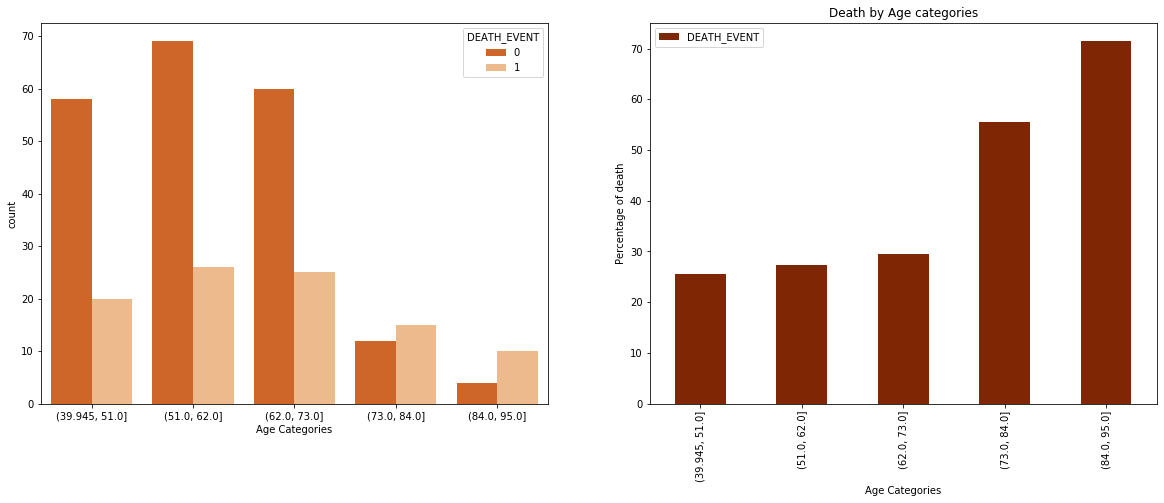

In [67]:
data['Age Categories'] = pd.cut(data['age'],5)
fig, axis = plt.subplots(1, 2, figsize=(20,7))
sns.countplot(x = 'Age Categories', hue = 'DEATH_EVENT', data = data, palette = 'Oranges_r',ax=axis[0])
print((data[['Age Categories','DEATH_EVENT']].groupby('Age Categories').mean()*100)
      .plot(kind='bar',title="Death by Age categories",colormap="Oranges_r",ax=axis[1])
     .set_ylabel("Percentage of death"))
plt.show()

##### From the above plots we can observe that the aged patients (84 - 95) are more likely to be not survived by the Heart failure.

#### We next create a derived column call 'creatinine_phosphokinase Categories' from original column 'creatinine_phosphokinase' where the values are segregated into 5 categories.

Text(0, 0.5, 'Percentage of death')


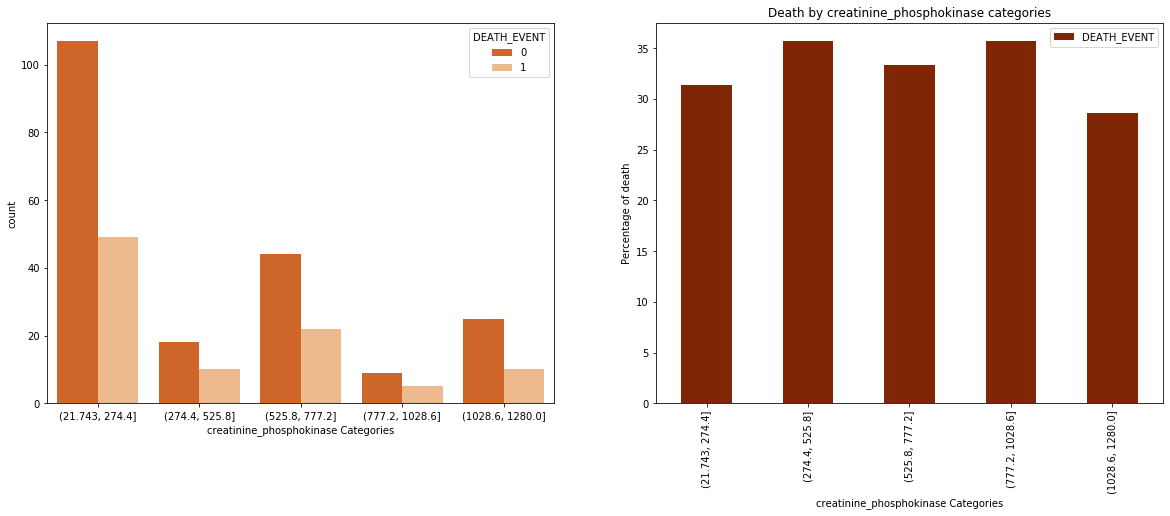

In [68]:
data['creatinine_phosphokinase Categories'] = pd.cut(data['creatinine_phosphokinase'],5)
fig, axis = plt.subplots(1, 2, figsize=(20,7))
sns.countplot(x = 'creatinine_phosphokinase Categories', hue = 'DEATH_EVENT', data = data, palette = 'Oranges_r',ax=axis[0])
print((data[['creatinine_phosphokinase Categories','DEATH_EVENT']].groupby('creatinine_phosphokinase Categories').mean()*100)
      .plot(kind='bar',title="Death by creatinine_phosphokinase categories",colormap="Oranges_r",ax=axis[1])
     .set_ylabel("Percentage of death"))
plt.show()

Text(0, 0.5, 'Percentage of death')


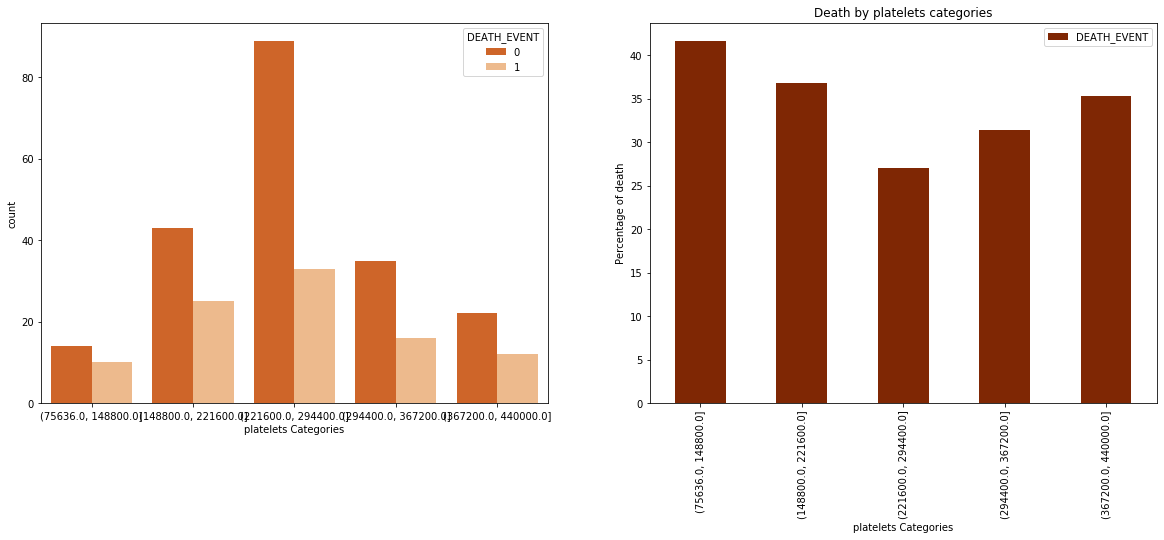

In [69]:
data['platelets Categories'] = pd.cut(data['platelets'],5)
fig, axis = plt.subplots(1, 2, figsize=(20,7))
sns.countplot(x = 'platelets Categories', hue = 'DEATH_EVENT', data = data, palette = 'Oranges_r',ax=axis[0])
print((data[['platelets Categories','DEATH_EVENT']].groupby('platelets Categories').mean()*100)
      .plot(kind='bar',title="Death by platelets categories",colormap="Oranges_r",ax=axis[1])
     .set_ylabel("Percentage of death"))
plt.show()

### Contingency Tables
A contingency table is a table showing the distribution of one variable in rows and another variable in columns. It is used to study the correlation between the two variables. It is a multiway table which describes a dataset in which each observation belongs to one category for each of several variables. Also It is basically a tally of counts between two or more categorical variables. Contingency tables are also called crosstabs or two-way tables,used in statistics to summarize the relationship between several categorical variables.

#### 1- High blood pressure and Death event

In [70]:
print("Contingency Table =>")
contingency= pd.crosstab(data['high_blood_pressure'], data['DEATH_EVENT']) 
contingency

Contingency Table =>


DEATH_EVENT,0,1
high_blood_pressure,,
0,137,57
1,66,39


In [71]:
print("P-value =>")
c, p, dof, expected = chi2_contingency(contingency) 
# Print the p-value
print(p)
alpha = 0.05
print("p value is " ,p)
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

P-value =>
0.21410341199416902
p value is  0.21410341199416902
Independent (H0 holds true)


##### High blood pressure and Death event are independent on each other
#### 2- smoking and Death event

In [72]:
print("Contingency Table =>")
contingency= pd.crosstab(data['smoking'], data['DEATH_EVENT']) 
contingency

Contingency Table =>


DEATH_EVENT,0,1
smoking,,
0,137,66
1,66,30


In [73]:
print("P-value =>")
c, p, dof, expected = chi2_contingency(contingency) 
# Print the p-value
print(p)
alpha = 0.05
print("p value is " ,p)
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

P-value =>
0.9317652998235507
p value is  0.9317652998235507
Independent (H0 holds true)


##### Smoking and Death_events are independent of each other

In [74]:
data.head(2)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,Age Categories,creatinine_phosphokinase Categories,platelets Categories
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1,"(73.0, 84.0]","(525.8, 777.2]","(221600.0, 294400.0]"
1,55.0,0,1280,0,38,0,263358.03,1.1,136,1,0,6,1,"(51.0, 62.0]","(1028.6, 1280.0]","(221600.0, 294400.0]"


#### Feature Selection

In [75]:
X = data.drop(['DEATH_EVENT','Age Categories','creatinine_phosphokinase Categories','platelets Categories'],axis=1)
y = data['DEATH_EVENT']

In [76]:
predictors = data.head(0)
selector = SelectKBest(chi2,k=5)
sf_fit = selector.fit(X,y)

In [77]:
c=[]
sf=[]
for i in range(len(sf_fit.scores_)):
    print(X.columns[i],":",sf_fit.scores_[i])
    c.append(X.columns[i])
    sf.append(sf_fit.scores_[i])

age : 44.619454569378306
anaemia : 0.7465934114891604
creatinine_phosphokinase : 4.213257191049663
diabetes : 0.0006568144499178924
ejection_fraction : 78.42169384091324
high_blood_pressure : 1.221538529204786
platelets : 14867.621456310466
serum_creatinine : 7.055536496390369
serum_sodium : 1.4684417353546453
sex : 0.001956265975995817
smoking : 0.032346828817734236
time : 3826.8926612912724


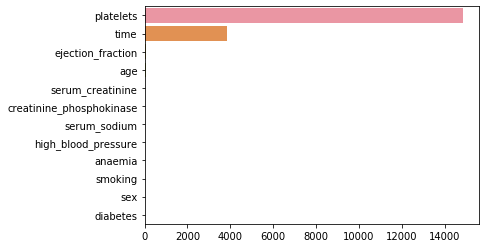

In [78]:
sf=pd.Series(sf)
sf.index=X.columns
sf.index
sf=sf.sort_values(ascending=False)
sns.barplot(y=sf.index,x=sf)

##### We can see that the last 3 colums do not affect our target variable greatly, hence we choose to drop these columns

In [79]:
X = X.drop(['diabetes','smoking','anaemia'],axis=1)

In [80]:
X.head()

,age,creatinine_phosphokinase,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,time
0,75.0,582,20,1,265000.00,1.90,130,1,4
1,55.0,1280,38,0,263358.03,1.10,136,1,6
2,65.0,146,20,0,162000.00,1.30,129,1,7
3,50.0,111,20,0,210000.00,1.90,137,1,7
4,65.0,160,20,0,327000.00,2.15,125,0,8


#### Cross Validation

In [81]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(StandardScaler(),RandomForestClassifier(n_estimators=30))

cross_val = cross_val_score(pipeline,X,y,cv=10)

print('Cross Validation Score : ',cross_val.mean()*100)

Cross Validation Score :  76.22988505747126


#### Train - Test Split

In [82]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

#### Standard Scaler
We have made use of Standard Scaler to resize the distribution of values so that the mean of the observed values is 0 and the standard deviation is 1. StandardScaler comes into play when the characteristics of the input dataset differ greatly between their ranges, or simply when they are measured in different units of measure. StandardScaler removes the mean and scales the data to the unit variance.

In [83]:
scaler = StandardScaler()

In [84]:
x_train['age'] = scaler.fit_transform(np.array(x_train['age']).reshape(-1,1))
x_test['age'] = scaler.transform(np.array(x_test['age']).reshape(-1,1))

x_train['creatinine_phosphokinase'] = scaler.fit_transform(np.array(x_train['creatinine_phosphokinase']).reshape(-1,1))
x_test['creatinine_phosphokinase'] = scaler.transform(np.array(x_test['creatinine_phosphokinase']).reshape(-1,1))

x_train['ejection_fraction'] = scaler.fit_transform(np.array(x_train['ejection_fraction']).reshape(-1,1))
x_test['ejection_fraction'] = scaler.transform(np.array(x_test['ejection_fraction']).reshape(-1,1))

x_train['platelets'] = scaler.fit_transform(np.array(x_train['platelets']).reshape(-1,1))
x_test['platelets'] = scaler.transform(np.array(x_test['platelets']).reshape(-1,1))

x_train['serum_creatinine'] = scaler.fit_transform(np.array(x_train['serum_creatinine']).reshape(-1,1))
x_test['serum_creatinine'] = scaler.transform(np.array(x_test['serum_creatinine']).reshape(-1,1))

x_train['serum_sodium'] = scaler.fit_transform(np.array(x_train['serum_sodium']).reshape(-1,1))
x_test['serum_sodium'] = scaler.transform(np.array(x_test['serum_sodium']).reshape(-1,1))

x_train['time'] = scaler.fit_transform(np.array(x_train['time']).reshape(-1,1))
x_test['time'] = scaler.transform(np.array(x_test['time']).reshape(-1,1))

### Data Modeling
#### We have used 3 models - Decision Tree Classifier, Random Forest Classifier and Gradient Boosting Classifier
#### Decision Tree Classifier

Accuracy of Decision Tree Classifier =>  75.0 %
Precision score of Decision Tree Classifier => 70.0
Recall score of Decision Tree Classifier => 60.87
f1 score of Decision Tree Classifier => 65.12

Confusion Matrix => 


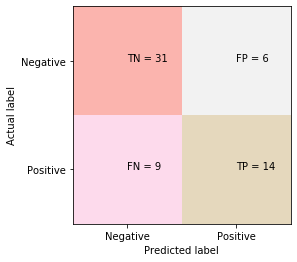

ROC Curve =>


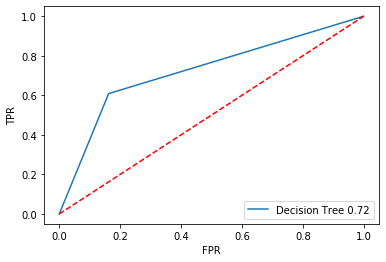

In [85]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
prediction = dtc.predict(x_test)
print("Accuracy of Decision Tree Classifier => ", np.round(accuracy_score(y_test,prediction)*100,2),"%")
dtc_accuracy=np.round(accuracy_score(y_test,prediction)*100,2)
precision = (precision_score(y_test,prediction))*100
print("Precision score of Decision Tree Classifier =>",np.round(precision,2))    
dtc_precision = np.round(precision,2)


recall = recall_score(y_test,prediction)*100
print("Recall score of Decision Tree Classifier =>",np.round(recall,2)) 
dtc_recall = np.round(recall,2)

f1 = f1_score(y_test,prediction)*100
print("f1 score of Decision Tree Classifier =>",np.round(f1,2))   
dtc_f1 = np.round(f1,2)

print("")
print("Confusion Matrix => ")

cm = confusion_matrix(y_test,prediction)
plt.clf()
plt.imshow(cm,cmap=plt.cm.Pastel1_r)
classname=['Negative','Positive']
tick_marks = np.arange(len(classname))
plt.xticks(tick_marks,classname)
plt.yticks(tick_marks,classname)
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
s = [['TN','FP'],['FN','TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i,str(s[i][j])+" = "+str(cm[i][j]))
        
plt.show()

print("ROC Curve =>")
fpr, tpr, threshold = roc_curve(y_test,prediction)
lr_roc_auc =roc_auc_score(y_test,prediction)
plt.figure()
plt.plot(fpr,tpr,label="Decision Tree {}".format(round(lr_roc_auc,2)))
plt.plot([0,1],[0,1],'r--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc='lower right')
plt.show()

### Confusion Matrix

##### TP - The passenger is satisfied and model has predicted it as satisfied
##### TN - The passenger is dissatisfied and model has predicted it as dissatisfied
##### FP - The passenger is dissatisfied and model has predicted it as satisfied
##### FN - The passenger is satisfied and model has predicted it as dissatisfied

### Model Evaluation

#### IF our dataset is imbalaned, then we can't really evaluate our model on basis of Accuracy. We have to check Precision Recall and F1 score
![](precision,recall.png)
![](f1.png)

Precision is a good measure to determine, when the costs of False Positive is high. For instance, airlines passenger satisfaction. In airlines passenger satisfaction, a false positive means that the passenger who was dissatisfied(actual negative) with the service has been categorized as satisfied. The airlines may fail in taking necessary measures to improve its service and result in loss of potential customers.

Recall is a good measure to determine, when there is a high cost associated with False Negative.
For instance, in fraud detection or sick patient detection. If a fraudulent transaction (Actual Positive) is predicted as non-fraudulent (Predicted Negative), the consequence can be very bad for the bank.

### ROC Curve
#### An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. 
#### The area under the curve of blue lines should be more

#### Random Forest Classifier

Accuracy of Random Forest Classifier =>  86.67 %
Precision score of Random Forest Classifier => 94.12
Recall score of Random Forest Classifier => 69.57
f1 score of Random Forest Classifier => 80.0

Confusion Matrix => 


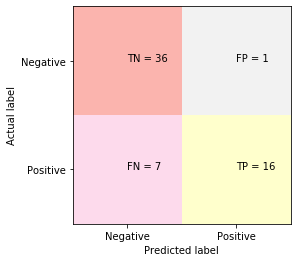

ROC Curve =>


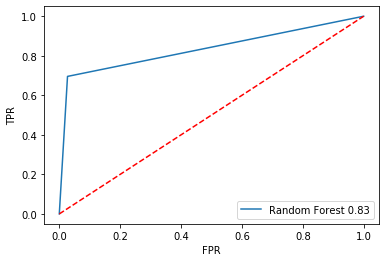

In [90]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=30)
rfc.fit(x_train, y_train)
prediction = rfc.predict(x_test)
print("Accuracy of Random Forest Classifier => ", np.round(accuracy_score(y_test,prediction)*100,2),"%")
rfc_accuracy = np.round(accuracy_score(y_test,prediction)*100,2)
precision = (precision_score(y_test,prediction))*100
print("Precision score of Random Forest Classifier =>",np.round(precision,2))  

rfc_precision = np.round(precision,2)

recall = recall_score(y_test,prediction)*100
print("Recall score of Random Forest Classifier =>",np.round(recall,2))    
rfc_recall = np.round(recall,2)

f1 = f1_score(y_test,prediction)*100
print("f1 score of Random Forest Classifier =>",np.round(f1,2))  
rfc_f1 = np.round(f1,2)

print("")
print("Confusion Matrix => ")
cm = confusion_matrix(y_test,prediction)
plt.clf()
plt.imshow(cm,cmap=plt.cm.Pastel1_r)
classname=['Negative','Positive']
tick_marks = np.arange(len(classname))
plt.xticks(tick_marks,classname)
plt.yticks(tick_marks,classname)
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
s = [['TN','FP'],['FN','TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i,str(s[i][j])+" = "+str(cm[i][j]))
        
plt.show()

print("ROC Curve =>")

fpr, tpr, threshold = roc_curve(y_test,prediction)
lr_roc_auc =roc_auc_score(y_test,prediction)
plt.figure()
plt.plot(fpr,tpr,label="Random Forest {}".format(round(lr_roc_auc,2)))
plt.plot([0,1],[0,1],'r--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc='lower right')
plt.show()

#### Gradient Boosting Classifier

Accuracy of GradientBoostingClassifier =>  85.0 %
Precision score of GradientBoostingClassifier => 93.75
Recall score of GradientBoostingClassifier => 65.22
f1 score of GradientBoostingClassifier => 76.92

Confusion Matrix => 


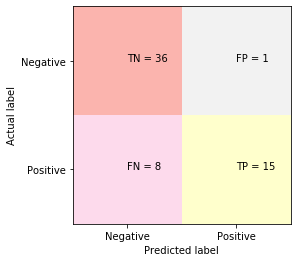

ROC Curve =>


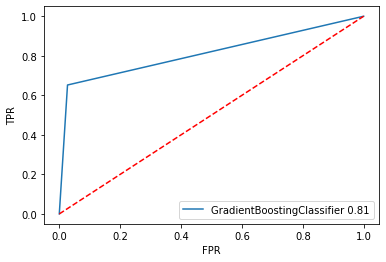

In [91]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=100,learning_rate=0.01,max_depth=3)
gbc.fit(x_train, y_train)
prediction = gbc.predict(x_test)
print("Accuracy of GradientBoostingClassifier => ", np.round(accuracy_score(y_test,prediction)*100,2),"%")
gbc_accuracy = np.round(accuracy_score(y_test,prediction)*100,2)
precision = (precision_score(y_test,prediction))*100
print("Precision score of GradientBoostingClassifier =>",np.round(precision,2))    
gbc_precision = np.round(precision,2)


recall = recall_score(y_test,prediction)*100
print("Recall score of GradientBoostingClassifier =>",np.round(recall,2))    
gbc_recall = np.round(recall,2)

f1 = f1_score(y_test,prediction)*100
print("f1 score of GradientBoostingClassifier =>",np.round(f1,2))  
gbc_f1 = np.round(f1,2)

print("")
print("Confusion Matrix => ")

cm = confusion_matrix(y_test,prediction)
plt.clf()
plt.imshow(cm,cmap=plt.cm.Pastel1_r)
classname=['Negative','Positive']
tick_marks = np.arange(len(classname))
plt.xticks(tick_marks,classname)
plt.yticks(tick_marks,classname)
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
s = [['TN','FP'],['FN','TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i,str(s[i][j])+" = "+str(cm[i][j]))
        
plt.show()

print("ROC Curve =>")
fpr, tpr, threshold = roc_curve(y_test,prediction)
lr_roc_auc =roc_auc_score(y_test,prediction)
plt.figure()
plt.plot(fpr,tpr,label="GradientBoostingClassifier {}".format(round(lr_roc_auc,2)))
plt.plot([0,1],[0,1],'r--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc='lower right')
plt.show()

### Conclusion
##### As mentioned earlier, we will be evaluating our models on the basis of accuracy as well as precision. Since precision is more vital to us in our scenario.

In [92]:
df = pd.DataFrame({'Classifier':['Decison Tree','Random Forest','Gradient Boosting'],
               'Accuracy':[dtc_accuracy,rfc_accuracy,gbc_accuracy],
              'Precision Score':[dtc_precision,rfc_precision,gbc_precision],
              'Recall Score':[dtc_recall,rfc_recall,gbc_recall],
              'F1 Score':[dtc_f1,rfc_f1,gbc_f1]
                })

df

,Classifier,Accuracy,Precision Score,Recall Score,F1 Score
0,Decison Tree,75.00,70.00,60.87,65.12
1,Random Forest,86.67,94.12,69.57,80.00
2,Gradient Boosting,85.00,93.75,65.22,76.92


### Among all the three models, Random Forest has the highest Precision Score(94.12) and F1 Score (80). So, we will select Random Forest Classifier Model for deployement

In [93]:
import pickle
pickle.dump(rfc,open('model.pkl','wb'))
pickle.dump(scaler,open('scaler.pkl','wb'))